In [ ]:
using CausalityTools
include("../entropy.jl")
using Random
using BenchmarkTools

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

est = Kraskov(k=1)

print("Current method :")
foo = @btime TE(Int.(a .> 0), Int.(b .> 0))
println("The result is $foo.\n")


print("True transfer entropy :")
a = float.(a)
b = float.(b)
foo2 = @btime transferentropy(a, b, est)
println("The result is $foo2.\n")

print("CCM :")
foo3 = @btime crossmap(a, b, 2, 1)
println("The result is $foo3.\n")

In [5]:
using StatsBase

a = [1 1 1 1 0 0]
b = [1 1 0 0 0 1]

countmap(a)

Dict{Int64, Int64} with 2 entries:
  0 => 2
  1 => 4

In [8]:
foo = [(a[i+1], a[i], b[i]) for i = 1:(length(a)-1)]


5-element Vector{Tuple{Int64, Int64, Int64}}:
 (1, 1, 1)
 (1, 1, 1)
 (1, 1, 0)
 (0, 1, 0)
 (0, 0, 0)

In [12]:
proportionmap(foo) 

Dict{Tuple{Int64, Int64, Int64}, Float64} with 4 entries:
  (0, 0, 0) => 0.2
  (1, 1, 1) => 0.4
  (1, 1, 0) => 0.2
  (0, 1, 0) => 0.2

In [32]:
include("../Utils/entropy.jl")


function transfer_entropy(X, Y)

    N = length(X)
    # configurations = [(Y[i+1], Y[i], X[i]) for i = 1:(N-1)]
    configurations = [(Y[i], Y[i-1], X[i-1]) for i = 2:N]
    states = proportionmap(configurations)

    tot = 0

    for state in keys(states)
        state_proba = states[state]
        # P_Yn_Xn = sum((Y .== state[2]) .& (X .== state[3])) / N
        # P_Yn1_Yn = sum((Y[2:end] .== state[1]) .& (Y[1:(end-1)] .== state[2])) / (N - 1)
        P_Yn_Xn = sum((Y[2:end] .== state[2]) .& (X[2:end] .== state[3])) / (N-1)
        P_Yn1_Yn = sum((Y[2:end] .== state[1]) .& (Y[1:(end-1)] .== state[2])) / (N - 1)
        # P_Yn = sum(Y .== state[2]) / N
        P_Yn = sum(Y[2:end] .== state[2]) / (N-1)

        numerator = state_proba / P_Yn_Xn
        denominator = P_Yn1_Yn / P_Yn

        tot += state_proba * log(numerator / denominator)

    end

    return tot

end


# a = [1 1 1 1 0 0]
# b = [1 1 0 0 0 1]

# a = rand(0:1, 100)
# b = rand(0:1, 100)

println("TE : $(TE(a,b))")
println("new : $(transfer_entropy(a,b))")

TE : 0.01723375678579247
new : 0.005963880456791892


In [30]:
X, Y = a, b
configurations = [(Y[i], Y[i-1], X[i-1]) for i = 2:length(X)]
states = proportionmap(configurations)

Dict{Tuple{Int64, Int64, Int64}, Float64} with 8 entries:
  (0, 0, 0) => 0.0606061
  (1, 1, 1) => 0.272727
  (1, 1, 0) => 0.191919
  (0, 1, 1) => 0.141414
  (0, 1, 0) => 0.0606061
  (1, 0, 1) => 0.131313
  (0, 0, 1) => 0.0707071
  (1, 0, 0) => 0.0707071

In [68]:
using CausalityTools
using StatsBase

func(x,y) = pvalue(jdd(OneSampleTTest, x, y, B=10, D=5, τ=1, μ0=0.0), tail=:right)

a = Vector{Int}(undef, 100)
b = Vector{Int}(undef, 100)

a[1:2:end] .= 0
a[2:2:end] .= 1
a[end-10:end] .= 2

b[1:2:end] .= 1
b[2:2:end] .= 0
b[end-10:end] .= 4

a = (a .- mean(a)) / std(a)
a = (b .- mean(b)) / std(b)

a = rand(0:3, 100)
b = rand(0:3, 100)

func(a,b)

0.0019527583546592735

In [1]:
using Dates
# using Revise
import PlotlyJS

include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

WebIO._IJuliaInit()

In [2]:
data.time_bin .= 0

690286-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [8]:
show(data[:, [3, 4, 5,6]])

690286×4 DataFrame
    Row │ sentiment  username         follower_count  time_bin 
        │ String     String           Int64           Int64    
────────┼──────────────────────────────────────────────────────
      1 │ negative   jeff_lizard                 179         0
      2 │ positive   Debatthebeach_            19635         0
      3 │ positive   mrmintslice                1411         0
      4 │ negative   lee_knuth                   438         0
      5 │ positive   Damsteegt                   672         0
      6 │ negative   Stephen67843639            1324         0
      7 │ neutral    kathleen_rebel               67         0
      8 │ positive   VincentBeaure10             172         0
      9 │ positive   007rgmweddings              491         0
     10 │ negative   Ludicris131                9009         0
     11 │ negative   Vikkik88                   3008         0
   ⋮    │     ⋮             ⋮               ⋮            ⋮
 690277 │ neutral    SallieT77303451 

In [ ]:
import PyPlot as plt

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

a = float.(a)
b = float.(b)

Ls = [10:5:50; 60:10:100]

@btime begin
    test = [crossmap(a[1:L], b[1:L], 2, 1) for L in Ls]
    test2 = [crossmap(b[1:L], a[1:L], 2, 1) for L in Ls]
end

plt.figure()
plt.plot(Ls, test, "b-", label="a to b")
plt.plot(Ls, test2, "r-", label="b to a")
plt.legend()
show(plt.gcf())

In [ ]:
using CausalityTools

s_measure()

In [ ]:
using CausalityTools

# A two-dimensional Ulam lattice map
sys = ulam(2)

# Sample 1000 points after discarding 5000 transients
orbit = trajectory(sys, 1000, Ttr = 5000)
x, y = orbit[:, 1], orbit[:, 2]

# 4-dimensional embedding for `x`, 5-dimensional embedding for `y`
s_measure(x, y, dx = 4, τx = 3, dy = 5, τy = 1)

In [ ]:
using DelayEmbeddings

a = collect(1:100)
p = embed(a, 2, 5)

In [ ]:
using Neighborhood

a = [0, 1.2, 0.1, 0.8]
b = [0, 0, 1.8, 0.8]


X = embed(a, 2, 1)
Y = embed(b, 2, 1)

treeX = searchstructure(KDTree, X, Euclidean())
treeY = searchstructure(KDTree, Y, Euclidean())
neighborhoodtype, theiler = NeighborNumber(1), Theiler(0)
idxs_X = bulkisearch(treeX, X, neighborhoodtype, theiler)
idxs_Y = bulkisearch(treeY, Y, neighborhoodtype, theiler)

print(idxs_Y)

In [ ]:
using CausalityTools
using BenchmarkTools

include("../Utils/entropy.jl")

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime s_measure(float(x), float(y), K=3, dx=5, dy=5, τx=1, τy=1)

@btime TE(Int.(x .> 0), Int.(y .> 0))

In [ ]:
using HypothesisTests

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime jdd(OneSampleTTest, x, y, B=10, D=2, τ=1)

In [ ]:
source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τs = 1

@btime Ex = DelayEmbeddings.embed(source, D, τs)
Ey = DelayEmbeddings.embed(target, D, τs)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

In [ ]:
import DelayEmbeddings

source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τ = 1

js = ([1 for i = 1:D]...,)
τs = (collect(0:-τ:-(D-1)*τ)...,)

Ex = DelayEmbeddings.genembed(source, τs, js)
Ey = DelayEmbeddings.genembed(target, τs, js)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

In [ ]:
Matrix(Ex) 

In [ ]:
foo = [0 1; 2 0]
LinearIndices(foo[foo .> 0])

In [ ]:
My

In [ ]:
Mx

In [ ]:
using Distances

pairwise(Euclidean(), Mx, Mx, dims=1)

In [ ]:
Euclidean()([2,1], [3,2])

In [ ]:
using BenchmarkTools
using CausalityTools

include("../Utils/entropy.jl")

B = 10
d = 3
τ = 1
alpha = 0.001

K = 3
dx = 3
dy = 3
τx = 1
τy = 1

cuttoff = 0.5
cuttoff2 = 0.01

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0)) > cuttoff ? 1 : 0
func3(x,y) = s_measure(float(x), float(y), K=K, dx=dx, dy=dy, τx=τx, τy=τy) > cuttoff2 ? 1 : 0

tot1 = 0
tot2 = 0
tot3 = 0
nans = 0
for i = 1:100
    x = rand(0:10, 30)
    y = rand(0:10, 30)

    tot1 += func1(x ,y)
    tot2 += func2(x ,y)
    tot3 += func3(x ,y)
end

println("jdd : $tot1")
println("TE : $tot2")
println("s measure : $tot3")

In [56]:
using BenchmarkTools
using CausalityTools
using StatsBase: minimum, maximum, mean, std

function standardize(x)
    std_ = std(x, dims=1)
    return (x .- mean(x, dims=1)) ./ ifelse.(std_ .> 0, std_, ones(size(std_)))
end

B = 10
d = 3
τ = 1
alpha = 0.001

cuttoff = 0.5
cuttoff2 = 0.01

Nts = 13*24*2

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0

tot = 0

for i = 1:10000
    x = standardize(rand(0:10, Nts))
    y = standardize(rand(0:10, Nts))

    # x = rand(0:10, Nts)
    # y = rand(0:10, Nts)

    tot += func(x ,y)
end

println("jdd : $tot")

jdd : 15


In [1]:
using Dates
# using Revise
import PlotlyJS

include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;


WebIO._IJuliaInit()

In [2]:
a = TimeSeriesGenerator(Minute(12), standardize=true)

LoadError: MethodError: no method matching TimeSeriesGenerator(::Minute; standardize=true)
[0mClosest candidates are:
[0m  TimeSeriesGenerator(::Period) at ~/Desktop/Thesis/Julia/Sensors/timeseries.jl:16[91m got unsupported keyword argument "standardize"[39m
[0m  TimeSeriesGenerator(::Period, [91m::Union{String, Symbol}[39m, [91m::Union{String, Symbol}[39m, [91m::Union{String, Symbol}[39m, [91m::Union{String, Symbol}[39m, [91m::Bool[39m) at ~/Desktop/Thesis/Julia/Sensors/timeseries.jl:8[91m got unsupported keyword argument "standardize"[39m
[0m  TimeSeriesGenerator(::Period, [91m::Bool[39m) at ~/Desktop/Thesis/Julia/Sensors/timeseries.jl:16[91m got unsupported keyword argument "standardize"[39m
[0m  ...

In [ ]:
using BenchmarkTools
using CausalityTools
using StatsBase

function normalize(x)
    return (x .- mean(x))/std(x)
end


B = 10
d = 3
τ = 1
alpha = 0.001

Nsurr = 50
p_value_surr = Vector{Float64}(undef, Nsurr)

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)

tot = 0
eviter = 0

for i = 1:1000
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    p = func(x, y)

    if p < alpha

        s = surrogenerator(x, RandomShuffle())

        for i = 1:Nsurr
            p_value_surr[i] = func(s(), y)
            # p_value_surr[i] = func(rand(0:10, 100), y)
        end

        limit = quantile(p_value_surr, 0.01)/4
        limit2 = minimum()

        if p < limit
            tot += 1
            println("p : $p    limit: $limit     limit2: $(limit2)")

        else
            eviter += 1
        end

    end

    #= if p < alpha
        tot += 1
    end =#

end

println("jdd : $tot")
println("We removed : $eviter")

In [ ]:
println(quantile(p_value_surr, 0.01)/4)
println(quantile(p_value_surr, 0.05)/4)
confint(OneSampleTTest(p_value_surr), 0.0001)

In [ ]:
x = 1:100
y = 101:200

p = func(x, y)

if p < alpha

    s = surrogenerator(x, RandomShuffle())

    for i = 1:Nsurr
        p_value_surr[i] = func(s(), y)
        # p_value_surr[i] = func(rand(0:10, 100), y)
    end

    limit = minimum(p_value_surr)/2 #quantile(p_value_surr, 0.05)

    println("p : $p    limit: $limit")

    if p < limit
        tot += 1
    end

end

In [ ]:
import PyPlot as plt
using Distributions

foo = fit_mle(Normal, p_value_surr)


show(plt.hist(p_value_surr, bins=20))
plt.plot(0:0.001:0.3, rand(foo, length(0:0.001:0.3)), "-r")
foo

In [ ]:
float.(p_value_surr)

In [ ]:
d = Normal()
x = rand(d, 100)



In [17]:
using CausalityTools

a = float([1, 2, 3, [0 for i = 1:99]...])

est = VisitationFrequency(RectangularBinning(2.))
# est = NaiveKernel(1.8)
# est = SymbolicPermutation()
probabilities(a, est)

LoadError: MethodError: no method matching probabilities(::Vector{Float64}, ::VisitationFrequency{RectangularBinning{Float64}})
[0mClosest candidates are:
[0m  probabilities(::AbstractVector{T}, [91m::SymbolicPermutation[39m) where T<:Real at ~/.julia/packages/Entropies/oqn2O/src/symbolic/SymbolicPermutation.jl:292
[0m  probabilities(::AbstractVector{T}, [91m::SymbolicWeightedPermutation[39m) where T<:Real at ~/.julia/packages/Entropies/oqn2O/src/symbolic/SymbolicWeightedPermutation.jl:34
[0m  probabilities(::AbstractVector{T}, [91m::SymbolicAmplitudeAwarePermutation[39m) where T<:Real at ~/.julia/packages/Entropies/oqn2O/src/symbolic/SymbolicAmplitudeAware.jl:40
[0m  ...

In [22]:
using CausalityTools

a = float([1 for i = 1:100])
b = float([1 for i = 1:100])

# est = Kraskov(k=3)
est = VisitationFrequency(RectangularBinning(10))
# est = NaiveKernel(1.8)
# est = SymbolicPermutation()
# probabilities(a, est)
transferentropy(a, b, est)

LoadError: InexactError: trunc(Int64, NaN)

In [53]:
include("../Utils/entropy.jl")
using StatsBase: mean

foo = []
for i = 1:10000
    a = rand(0:1, 26)
    b = rand(0:1, 26)

    push!(foo, TE(a, b))
end

maximum(foo)

NaN

In [55]:
sum(foo .> 0.5)

43

In [ ]:
using CausalityTools

a = collect(1:30)
b = collect(51:80)

a = [[0 for i in 1:30]..., a...]
b = [[0 for i in 1:30]..., b...]

B = 10
d = 3
τ = 5
alpha = 0.001

func(x,y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)
func(a, b)

In [ ]:
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0))

nans = 0
for i = 1:100
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    isnan(func2(x,y)) ? nans += 1 : nans += 0
end

nans

In [ ]:
x = rand(0:10, 30)
y = rand(0:10, 30)

B = 10
d = 3
τ = 1
alpha = 0.001

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
@btime func1(x,y)

In [ ]:
foo = zeros(3,3)
try
    a = minimum(foo[foo .> 0])
catch
    print("foo")
end

In [ ]:
est = VisitationFrequency(RectangularBinning(10))

n = 1000
# Source and target variables
s, t = rand(n), rand(n)


est = NaiveKernel(0.3)
@btime bbnue(s, t, est)

In [ ]:
using CausalityTools

a = float([[0 for i = 1:24]..., 1, [0 for i = 1:75]...])
b = float([[0 for i = 1:36]..., 1, [0 for i = 1:63]...])

a = (a .- mean(a)) / std(a)
b = (b .- mean(b)) / std(b)

transferentropy(a, b, Kraskov(k=3))

In [ ]:
using Dates

start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

println(floor(start_time, time_interval))
println(ceil(end_time, time_interval))

In [ ]:
start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, time_interval)
    end_time = ceil(end_time, time_interval)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

create_time_intervals(start_time, end_time, time_interval)

start_time

In [ ]:
Minute <: Period

In [ ]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

In [ ]:
start_time = minimum(data.created_at)
println(start_time)
println(floor(start_time, Minute))

In [ ]:
end_time = maximum(data.created_at)
println(end_time)
println(ceil(end_time, Minute))

In [ ]:

start_time = minimum(data.created_at)
end_time = maximum(data.created_at)
time_interval = Hour(5)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, Minute)
    end_time = ceil(end_time, Minute)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

foo = create_time_intervals(start_time, end_time, time_interval)

In [ ]:
length(foo) - 1

In [ ]:
total_min = 5*60

clean_dates = x -> floor(x, Dates.Minute(total_min))
data.time = clean_dates.(data."created_at")

In [ ]:
a = Vector{Int}(undef, 2)

In [ ]:
isassigned(a, 3)

In [ ]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers
include("../Sensors/Sensors.jl")
import .Sensors as sen

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");



In [ ]:
foo = x -> floor(x, Minute)
time = foo.(data.created_at)

In [ ]:
println(length(unique(time)))
println(24*60*39)


In [ ]:
13*24/2

In [5]:
5 ÷ 2

2

In [3]:
isodd(3)

true

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

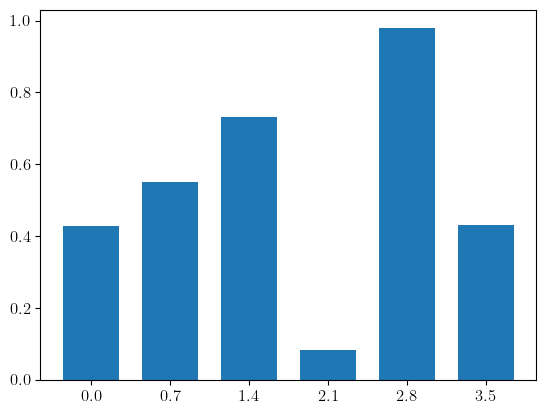

In [27]:
include("../Sensors/Sensors.jl")
include("../Utils/Visualizations.jl")
using .Visualizations;
import PyPlot as plt

Nbar = 1
x_length = 6
width = 0.5
spacing = 0.2

Y = rand(Nbar, x_length)
X, ticks = Visualizations.barplot_layout(Nbar, x_length, width=width, spacing=spacing)

plt.figure()
for i = 1:Nbar
    plt.bar(X[i, :], Y[i, :], width=width, label="$i", zorder=2)
end
plt.xticks(ticks)
show(plt.gcf())

In [30]:
x = rand(4)
[x... [0. for i = 1:3]...]

1×7 Matrix{Float64}:
 0.535588  0.496839  0.296448  0.322843  0.0  0.0  0.0

In [17]:
using Revise
include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

a = [0.1 0.2;0.05 0.2]
b = [0.8 0.2;0.6 0.1]
c = [0.1 0.2;0.2 0]
d = [0.9 0.2;0.6 0.7]
e = [0 0;0 0]

B = Matrix{Matrix{Float64}}(undef, 3, 3)

B[1,1] = e
B[1,2] = b
B[1,3] = e
B[2,1] = e
B[2,2] = e
B[2,3] = d
B[3,1] = e
B[3,2] = e
B[3,3] = e

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff, false)

cascades_A = observe(B, icg)

1-element Vector{InfluenceCascade}:
 InfluenceCascade(OrderedDict{AbstractString, Matrix}("0 => 1" => [0.8 0.0; 0.6 0.0], "1 => 2" => [0.9 0.0; 0.6 0.7]), OrderedDict{AbstractString, Vector{Tuple{Int64, Int64}}}("0 => 1" => [(1, 2)], "1 => 2" => [(2, 3)]), [1, 1, 1], 1, false)

In [16]:
B

3×3 Matrix{Matrix{Float64}}:
 [0.0 0.0; 0.0 0.0]  [0.8 0.2; 0.6 0.1]  [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  [0.9 0.2; 0.6 0.7]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]

In [28]:
include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

f = [1.2 0.3 0.; 0.7 0.3 0.3; 0. 0.6 0.]
g = [0.3 0.3 0.3; 0.2 0.9 0.8; 0.3 0.9 0.]
h = zeros(3,3)

C = Matrix{Matrix{Float64}}(undef, 4, 4)

for i in 1:size(C,1), j in 1:size(C,2)
    C[i,j] = h
end

C[1, 4] = f
C[2,1] = g
C[3,4] = f
C[4,1] = g

D = Matrix{Matrix{Float64}}(undef, 4, 4)

for i in 1:size(C,1), j in 1:size(C,2)
    D[i,j] = h
end

D[1, 2] = f
D[1, 4] = f
D[2,3] = g
D[3,2] = f
D[4,2] = g

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff, false)

cascades = observe(D, icg)
println(cascades[1].actor_edges)
println(cascades[1].actors_per_level)

OrderedDict{AbstractString, Vector{Tuple{Int64, Int64}}}("0 => 1" => [(1, 2), (1, 4)], "1 => 2" => [(2, 3), (4, 2)], "2 => 3" => [(3, 2)])
[1, 2, 2, 1]


In [26]:
println(cascades[2].actor_edges)
println(cascades[2].actors_per_level)

OrderedDict{AbstractString, Vector{Tuple{Int64, Int64}}}("0 => 1" => [(3, 4)], "1 => 2" => [(4, 1)], "2 => 3" => [(1, 4)])
[1, 1, 1, 1]


In [32]:
using DataStructures

a = Queue{Int}()

enqueue!(a, 2)
enqueue!(a, 2)
a

Queue{Int64}(Deque [[2, 2]])

In [30]:
foo = dequeue!(a)

2

In [2]:
import Random

rng = Random.Xoshiro(123)

a = rand(rng, 10, 10)
b = rand(rng, 10, 10)

10×10 Matrix{Float64}:
 0.954159   0.705747  0.656091  0.732299  …  0.865221  0.923886  0.501787
 0.845895   0.991961  0.492297  0.439982     0.228402  0.546804  0.940805
 0.586749   0.740841  0.100781  0.960804     0.197021  0.460865  0.496143
 0.121813   0.229042  0.878875  0.299572     0.32906   0.702991  0.597685
 0.137766   0.96917   0.590084  0.639659     0.985006  0.284711  0.129922
 0.0508083  0.540529  0.765927  0.660925  …  0.486825  0.301949  0.407486
 0.38644    0.639715  0.310826  0.357289     0.915104  0.712624  0.541886
 0.846458   0.227688  0.018445  0.45545      0.741824  0.459458  0.776189
 0.123538   0.267809  0.160885  0.519318     0.386815  0.619829  0.0716803
 0.74002    0.83098   0.605897  0.17096      0.920633  0.292777  0.932684

In [3]:
rng1 = Random.Xoshiro(123)

a1 = rand(rng1, 10, 10)
b1 = rand(rng1, 10, 10)

10×10 Matrix{Float64}:
 0.954159   0.705747  0.656091  0.732299  …  0.865221  0.923886  0.501787
 0.845895   0.991961  0.492297  0.439982     0.228402  0.546804  0.940805
 0.586749   0.740841  0.100781  0.960804     0.197021  0.460865  0.496143
 0.121813   0.229042  0.878875  0.299572     0.32906   0.702991  0.597685
 0.137766   0.96917   0.590084  0.639659     0.985006  0.284711  0.129922
 0.0508083  0.540529  0.765927  0.660925  …  0.486825  0.301949  0.407486
 0.38644    0.639715  0.310826  0.357289     0.915104  0.712624  0.541886
 0.846458   0.227688  0.018445  0.45545      0.741824  0.459458  0.776189
 0.123538   0.267809  0.160885  0.519318     0.386815  0.619829  0.0716803
 0.74002    0.83098   0.605897  0.17096      0.920633  0.292777  0.932684

In [5]:
b == b1

true

In [1]:
include("../Sensors/Sensors.jl")
using .Sensors;
import Random

rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)

foo.causal_function(a, b)

0.3482130328525459

In [1]:
include("../Sensors/Sensors.jl")
using .Sensors;
import Random

rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)

foo.causal_function(a, b)

0.3482130328525459

In [2]:
rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)

foo.causal_function(a, b)

0.3482130328525459

In [4]:
rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)


foo.causal_function(a, b)

0.3482130328525459

In [16]:
a = Matrix{Matrix{Float64}}(undef, 2, 2)
foo1 = [ 1 2; 3 4]
foo2_ = [0.1 0.3; 2.1 3.1]
foo3 = [0 0; 2 1]
foo4 = [0 3; 1 0]
a[1, 1] = foo1
a[1, 2] = foo2_
a[2, 1] = foo3
a[2, 2] = foo4

N_actions = 2
cuttoff = 0.5
edge_number = zeros(4)

linear_index = 0
for i = 1:N_actions, j = 1:N_actions
    linear_index += 1
    simplifier = x -> (x[i, j] > cuttoff)
    edge_number[linear_index] = sum(simplifier.(a))
end

In [20]:
simplifier = x -> (x[1, 1] > cuttoff)
sum(simplifier.(a))

1

In [38]:
edge_number = Matrix{Float64}(undef, 3, 5)
edge_number[1,:] = collect(1:5)
edge_number[2,:] = collect(6:10)
edge_number[3,:] = collect(11:15)

reorder = [2,1,3]
edge_number[reorder, :]

3×5 Matrix{Float64}:
  6.0   7.0   8.0   9.0  10.0
  1.0   2.0   3.0   4.0   5.0
 11.0  12.0  13.0  14.0  15.0

In [26]:
edge_number

3×5 Matrix{Int64}:
  1   2   3   4   5
  6   7   8   9  10
 11  12  13  14  15

In [39]:
edge_number ./= sum(edge_number, dims=2)

3×5 Matrix{Float64}:
 0.0666667  0.133333  0.2  0.266667  0.333333
 0.15       0.175     0.2  0.225     0.25
 0.169231   0.184615  0.2  0.215385  0.230769

In [43]:
edge_number[3,:] .* 65

5-element Vector{Float64}:
 11.0
 12.0
 13.0
 14.0
 15.0

In [36]:
edge_number

3×5 Matrix{Int64}:
  1   2   3   4   5
  6   7   8   9  10
 11  12  13  14  15

In [44]:
"test " .* ["givsaiu", "bp^", "bhbipp"]

3-element Vector{String}:
 "test givsaiu"
 "test bp^"
 "test bhbipp"

In [48]:
split("test", '/')

1-element Vector{SubString{String}}:
 "test"

In [55]:
function foo()
    replace("test_56", '_' => ' ')
    plot_name = uppercase("actor frequency")
    @warn "The plot of $plot_name will not be saved because this would overwrite it."
end

foo (generic function with 2 methods)

In [60]:
using Logging
with_logger(foo, NullLogger())

In [63]:
f() = 2*2

f (generic function with 1 method)